# Cognitive decline classification
## Miren Tamayo-Elizalde, Ph.D.
### February 2022

In [1]:
# import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

# Ignore sklearn warning for now
import warnings
warnings.filterwarnings('ignore') 

# Aim
This notebook explores different demographics data and cognitive scores from over 270 patients, and evaluates several common ML models to classify them into showing cognitive decline (label = 1) and not showing cognitive decline (label = 0). Further, the most relevant features for each model are selected.


# Outline
1. Data exploration and pre-processing
2. Baseline with all features
3. Feature selection
3. Final model: SVC(Linear) with selected features


# 1. Data exploration and pre-processing

## Load train and test data

In [34]:
X_train = pd.read_csv('train_data.csv')

In [35]:
X_train.head()

,id,demographic_field_1,demographic_field_2,demographic_field_3,demographic_field_4,demographic_field_5,aggregated_scores_1,aggregated_scores_2,aggregated_scores_3,aggregated_scores_4,...,sequential_performance_22,sequential_performance_23,sequential_performance_24,sequential_performance_25,sequential_performance_26,sequential_performance_27,sequential_performance_28,sequential_performance_29,sequential_performance_30,label
0,train_1,72.0,13.0,1.0,1.0,0.0,1.0,10.0,69.4235,81.4708,...,20.0,18.200000,4.500000,4.076475,1.0,14.0,1.055556,0.235702,2.0,1
1,train_2,62.0,11.0,1.0,1.0,1.0,1.0,10.0,59.0160,79.3770,...,24.0,18.500000,4.705882,5.193322,1.0,19.0,1.250000,0.447214,2.0,0
2,train_3,82.0,15.0,0.0,1.0,1.0,2.0,40.0,51.3012,74.3402,...,30.0,11.800000,3.571429,4.272838,1.0,15.0,1.250000,0.444262,2.0,1
3,train_4,86.0,9.0,1.0,0.0,1.0,2.0,40.0,27.9054,59.4747,...,57.0,3.789474,2.541667,3.064228,1.0,15.0,1.625000,0.710939,3.0,1
4,train_5,73.0,11.0,1.0,1.0,1.0,2.0,30.0,34.5373,61.3705,...,65.0,2.984615,2.952381,2.673503,1.0,11.0,1.900000,1.020836,4.0,1


In [36]:
X_train.columns

Index(['id', 'demographic_field_1', 'demographic_field_2',
       'demographic_field_3', 'demographic_field_4', 'demographic_field_5',
       'aggregated_scores_1', 'aggregated_scores_2', 'aggregated_scores_3',
       'aggregated_scores_4',
       ...
       'sequential_performance_22', 'sequential_performance_23',
       'sequential_performance_24', 'sequential_performance_25',
       'sequential_performance_26', 'sequential_performance_27',
       'sequential_performance_28', 'sequential_performance_29',
       'sequential_performance_30', 'label'],
      dtype='object', length=298)

In [37]:
y_train = X_train.label
# patient ID does not affect the prediction of the label
X_train = X_train.drop(['label', 'id'], axis=1)

Now X_train contain all the features.

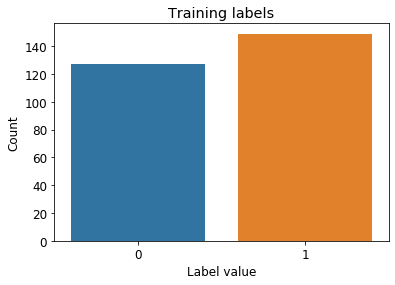

In [38]:
# visualise labels
sns.countplot(y_train)
plt.title('Training labels')
plt.xlabel('Label value')
plt.ylabel('Count')
plt.savefig('Training labels.png',dpi = 400, bbox_inches='tight')
plt.show()

In [39]:
X_test = pd.read_csv('test_data.csv')

In [40]:
X_test.head()

,id,demographic_field_1,demographic_field_2,demographic_field_3,demographic_field_4,demographic_field_5,aggregated_scores_1,aggregated_scores_2,aggregated_scores_3,aggregated_scores_4,...,sequential_performance_21,sequential_performance_22,sequential_performance_23,sequential_performance_24,sequential_performance_25,sequential_performance_26,sequential_performance_27,sequential_performance_28,sequential_performance_29,sequential_performance_30
0,test_1,60.0,15.0,1.0,1.0,0.0,NaN,10.0,73.0702,90.7424,...,1934.0,9.0,214.888889,11.500000,19.704967,1.0,59.0,1.142857,0.377964,2.0
1,test_2,61.0,13.0,1.0,1.0,0.0,NaN,20.0,68.1268,84.5149,...,361.0,16.0,22.562500,5.666667,3.330952,1.0,14.0,1.071429,0.267261,2.0
2,test_3,58.0,16.0,0.0,1.0,1.0,NaN,20.0,56.4412,87.2712,...,802.0,11.0,72.909091,9.000000,8.844333,1.0,31.0,1.111111,0.333333,2.0
3,test_4,62.0,18.0,1.0,0.0,0.0,NaN,10.0,66.4543,93.3223,...,1085.0,4.0,271.250000,19.200000,7.596052,11.0,30.0,1.000000,0.000000,1.0
4,test_5,78.0,12.0,0.0,1.0,1.0,NaN,20.0,73.1956,87.5177,...,690.0,12.0,57.500000,6.769231,7.617456,1.0,29.0,1.000000,0.000000,1.0


In [41]:
patientId = X_test['id'] # save it to generate the output csv file at the end
X_test = X_test.drop(['id'], axis = 1)

In [42]:
print('Train data shape: ' + str(X_train.shape))
print('Train labels shape: ' + str(y_train.shape))
print('Test data shape: ' + str(X_test.shape))

Train data shape: (276, 296)
Train labels shape: (276,)
Test data shape: (220, 296)


## Identify missing values

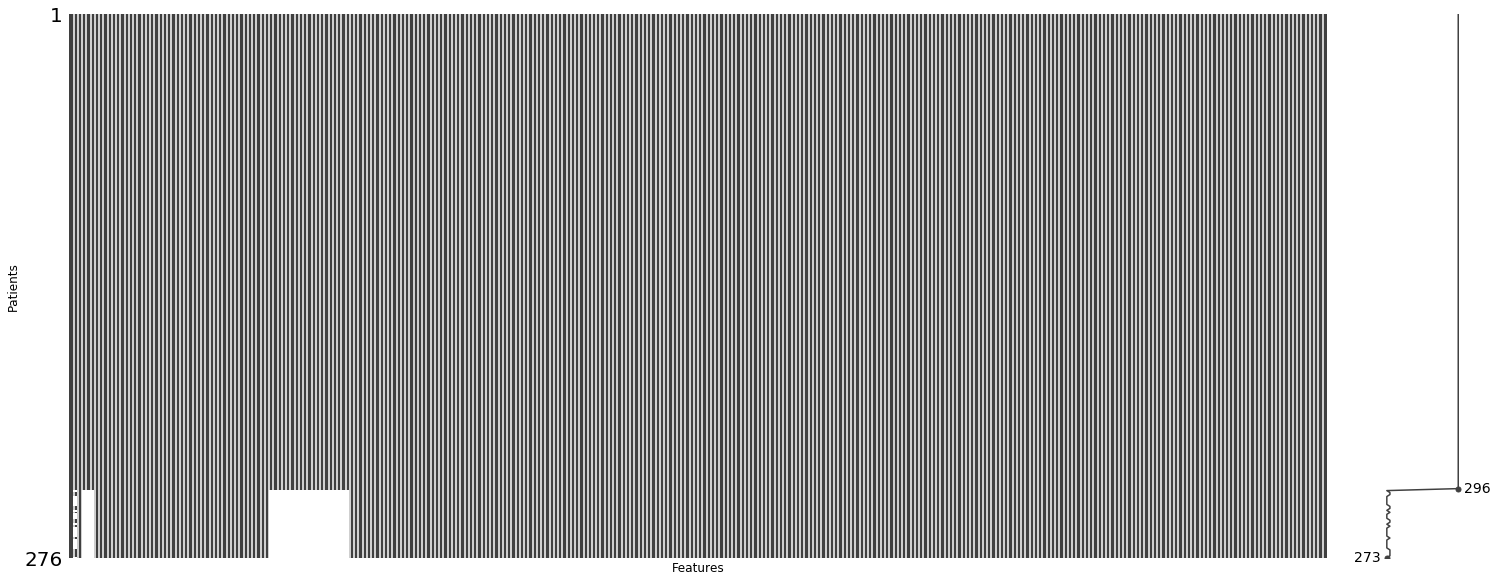

In [43]:
msno.matrix(X_train)
plt.ylabel('Patients')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})
plt.show()

Some of the patients in the training set have data missing in some features/variables.

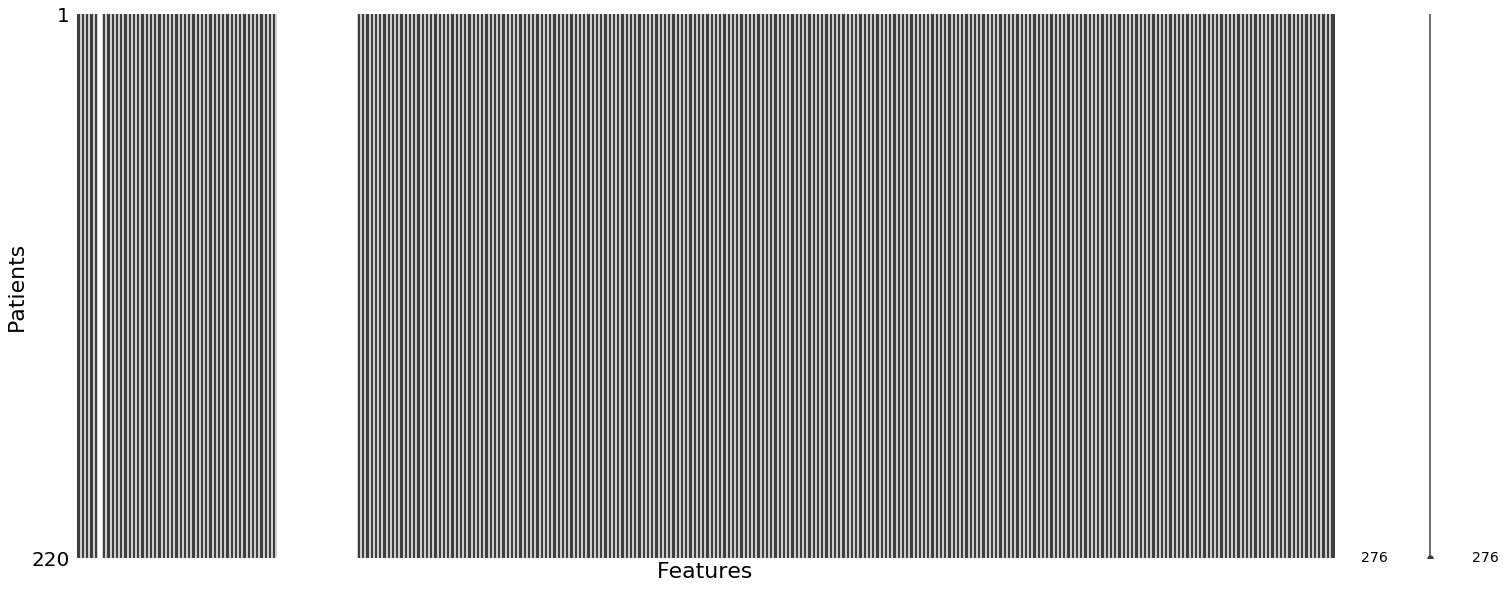

In [44]:
msno.matrix(X_test)
plt.ylabel('Patients')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})
plt.show()

All of the patients in the test set have data missing in the same features/variables as the train set. As we cannot use these variables to predict the label in the test set, it does not make sense to use them in the training either - we will drop them in both datasets.

In [45]:
# identify empty columns
missing_test = X_test.isnull().sum()
del_col = missing_test[missing_test != 0]
del_col # columns to delete

aggregated_scores_1     220
aggregated_scores_43    220
aggregated_scores_44    220
aggregated_scores_45    220
aggregated_scores_46    220
aggregated_scores_47    220
aggregated_scores_48    220
aggregated_scores_49    220
aggregated_scores_50    220
aggregated_scores_51    220
aggregated_scores_52    220
aggregated_scores_53    220
aggregated_scores_54    220
aggregated_scores_55    220
aggregated_scores_56    220
aggregated_scores_57    220
aggregated_scores_58    220
aggregated_scores_59    220
aggregated_scores_60    220
aggregated_scores_61    220
dtype: int64

In [46]:
# delete empty columns in training and test sets
X_train = X_train.drop(del_col.index[:], axis = 1)
X_test = X_test.drop(del_col.index[:], axis = 1)

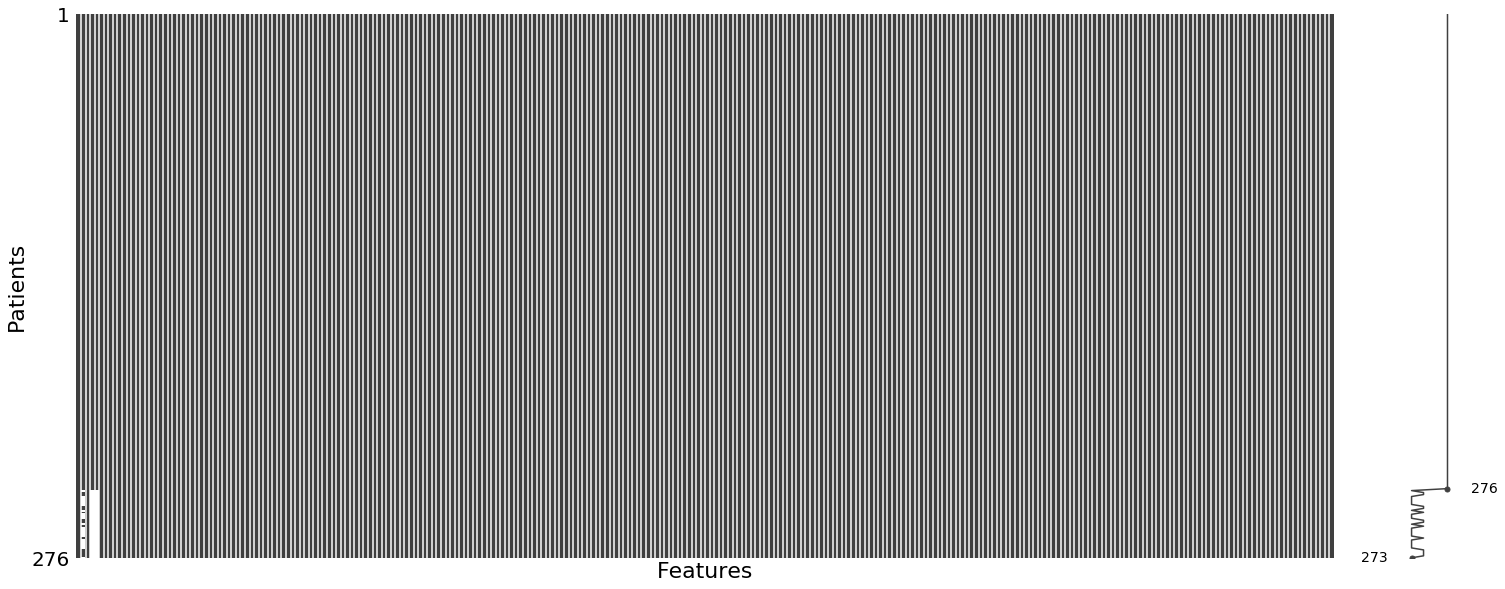

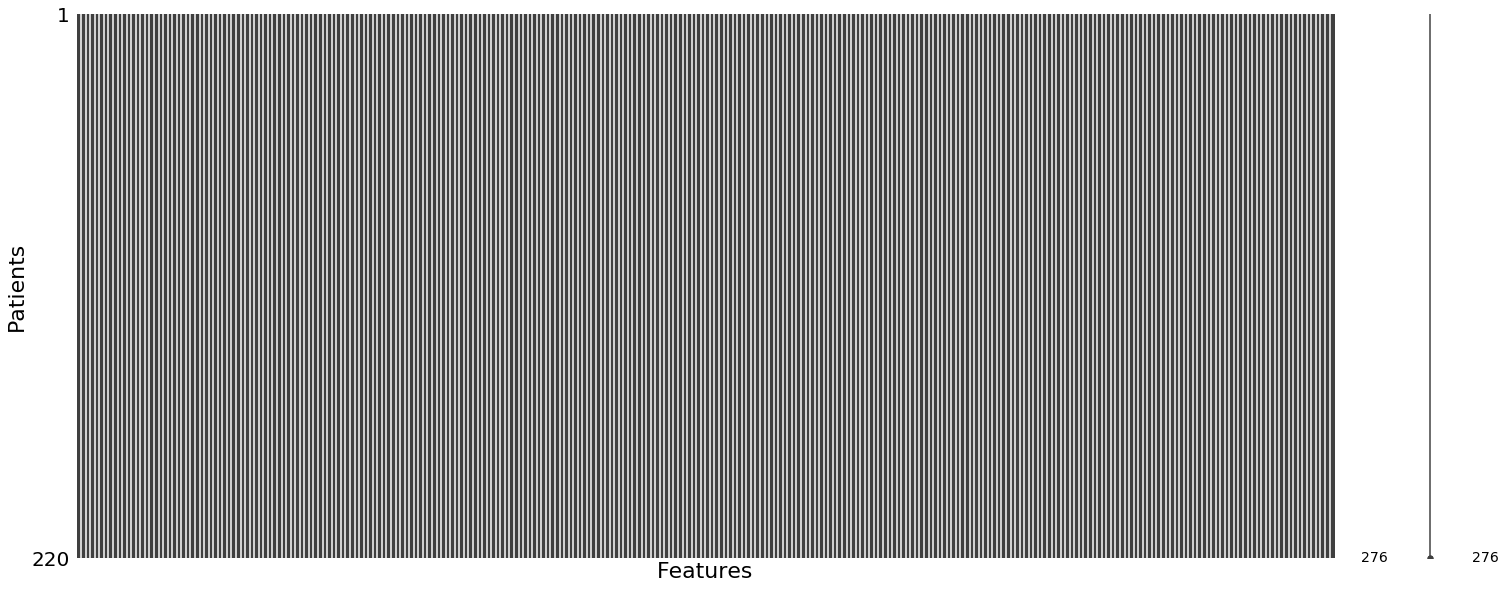

In [47]:
msno.matrix(X_train)
plt.ylabel('Patients')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})

msno.matrix(X_test)
plt.ylabel('Patients')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})
plt.show()

There are still a few patients (rows) in the train data with missing values. The test data is clean now.

In [48]:
X_train.tail()

,demographic_field_1,demographic_field_2,demographic_field_3,demographic_field_4,demographic_field_5,aggregated_scores_2,aggregated_scores_3,aggregated_scores_4,aggregated_scores_5,aggregated_scores_6,...,sequential_performance_21,sequential_performance_22,sequential_performance_23,sequential_performance_24,sequential_performance_25,sequential_performance_26,sequential_performance_27,sequential_performance_28,sequential_performance_29,sequential_performance_30
271,65.0,12.0,1.0,NaN,NaN,10.0,69.2326,94.4374,97.0,71.3738,...,1637.0,3.0,545.666667,24.250000,16.580611,6.0,46.0,1.000000,0.000000,1.0
272,71.0,12.0,1.0,NaN,NaN,10.0,79.9566,83.5508,82.0,97.5080,...,562.0,18.0,31.222222,4.555556,6.270587,1.0,28.0,1.000000,0.000000,1.0
273,57.0,12.0,1.0,NaN,NaN,10.0,68.1642,82.9126,83.0,82.1255,...,365.0,23.0,15.869565,5.533333,3.661902,1.0,14.0,1.214286,0.801784,4.0
274,59.0,12.0,0.0,NaN,NaN,10.0,66.5837,90.0374,92.0,72.3736,...,984.0,8.0,123.000000,10.222222,10.814085,1.0,37.0,1.000000,0.000000,1.0
275,59.0,NaN,1.0,NaN,NaN,10.0,57.7497,82.4750,84.0,68.7496,...,414.0,20.0,20.700000,6.000000,4.296689,1.0,14.0,1.230769,0.599145,3.0


In [49]:
# identify NaN values in train data to be replaced with the mean of each column
missing_train = X_train.isnull().sum()
repl_col = missing_train[missing_train != 0]

In [50]:
#replace NaN values with mean from each colum in data
for i in range (0, len(repl_col)):
    X_train[repl_col.index[i]] = X_train[repl_col.index[i]].fillna(X_train[repl_col.index[i]].mean())

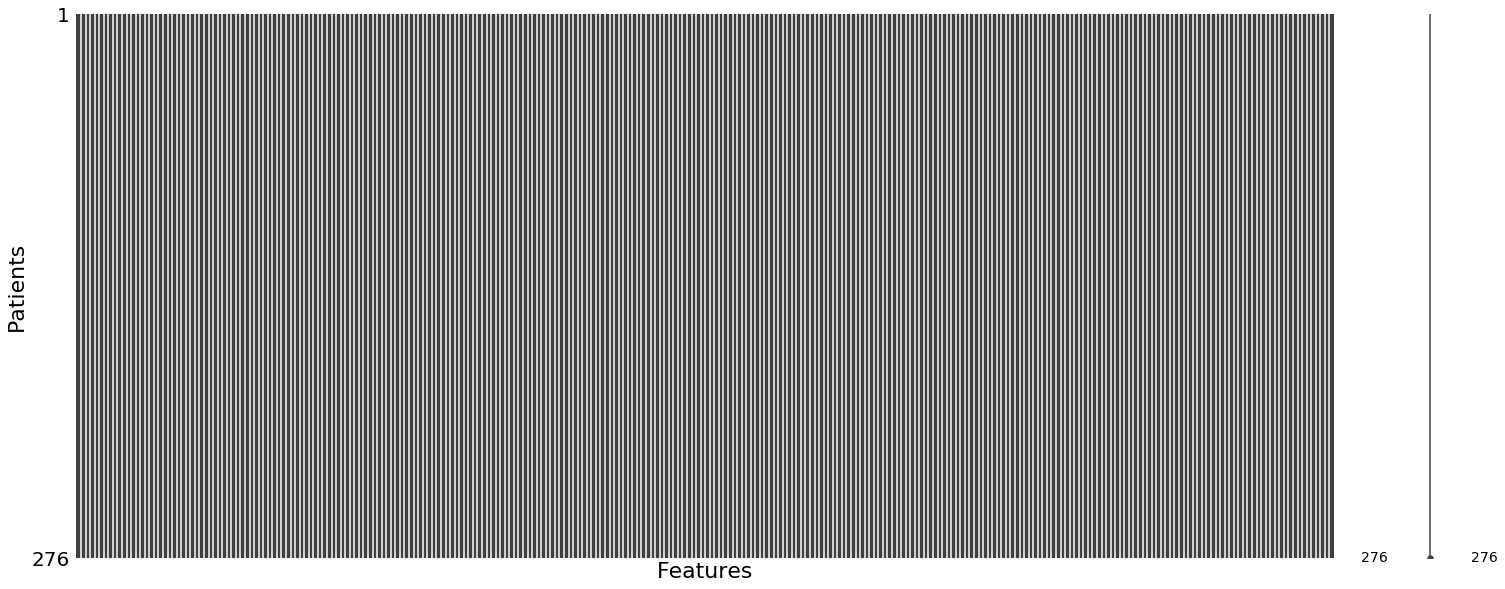

In [51]:
msno.matrix(X_train)
plt.ylabel('Patients')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})
plt.show()

There are no more missing values

In [52]:
print('Clean train data shape: ' + str(X_train.shape))
print('Train labels shape: ' + str(y_train.shape))
print('Clean test data shape: ' + str(X_test.shape))

Clean train data shape: (276, 276)
Train labels shape: (276,)
Clean test data shape: (220, 276)


Now let's check that the columns are the same in both data sets

In [53]:
X_train.columns.difference(X_test.columns)

Index([], dtype='object')

In [54]:
X_test.columns.difference(X_train.columns)

Index([], dtype='object')

There are no differences between the column names in both data sets, thus they are the same.

In [55]:
col_names = X_train.columns #save column names

## Save clean train and test sets as csv files

In [56]:
X_train.to_csv('train_set_features.csv', index = False)
y_train.to_csv('train_set_labels.csv', index = False)
X_test.to_csv('test_set_features.csv', index = False)

## Scale training data

In [57]:
# scale training data, so that each feature/column has mean 0 and std 1    
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Baseline with all the features

## Compare classifiers with all features

We will compare the following ML models, commonly used for supervised data classification: random forest (RF), k-nearest neighbors (knn), linear support vector classifier (SVC) and logistic regression (LogReg).

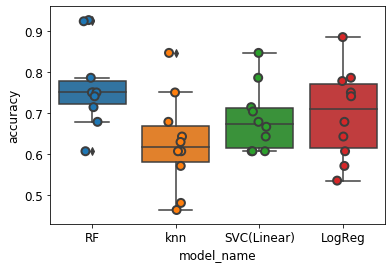

In [59]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    KNeighborsClassifier(n_neighbors=50),
    SVC(kernel='linear', random_state=0),
    LogisticRegression(random_state=0)]

model_names = [
    'RF',
    'knn',
    'SVC(Linear)',
    'LogReg']
  
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for i, model in enumerate(models):
    model_name = model_names[i]
    accuracies = cross_val_score(model, X_train, y_train, cv = CV,scoring = 'accuracy')
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x ='model_name', y = 'accuracy', data = cv_df)
sns.stripplot(x ='model_name', y = 'accuracy', data = cv_df, 
              size = 8, jitter = True, edgecolor = "gray", linewidth = 2)

plt.rcParams.update({'font.size': 12})
plt.savefig('baseline.png',dpi = 400, bbox_inches='tight')
plt.show()

In [60]:
for method_name in model_names:
    val_acc = np.asarray(list(map(lambda x: x[2] if x[0] == method_name else 0, np.asarray(cv_df)))).sum()/CV
    print('Method: {} - Acc: {:.2f}'.format(method_name, val_acc))

Method: RF - Acc: 0.76
Method: knn - Acc: 0.63
Method: SVC(Linear) - Acc: 0.69
Method: LogReg - Acc: 0.70


As per its accuracy, knn is not a reliable machine learning classifier for this data set - we will drop it for now and try to improve the other models' performances by selecting the most important features. The benefits of this are three fold: 1) speed up training, 2) avoid overfitting and 3) lead to better classification results due to the reduced noise in the data.

# 3. Feature selection

We look at feature selection (through Recursive Feature Elimination, RFE) for the most promising classifiers: RF, SVC and LogReg

## Classifiers comparison with selected features

In [62]:
X_train = pd.DataFrame(X_train, columns=col_names) # convert from numpy to dataframe

models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    SVC(kernel='linear', random_state=0),
    LogisticRegression(random_state=0)
]

model_names = [
    'RF',
    'SVC(linear)',
    'LogReg'
]


CV = 10
start = 10
step = 20
entries = []
acc_dict = {}

for model_name in model_names:
    acc_dict[model_name] = []

for n_feats in range(start, 276, step):
    
    for i, model in enumerate(models):
        val_acc = 0
        
        rfe = RFE(model, n_feats)
        rfe = rfe.fit(X_train, y_train.values.ravel())
        X_train_sel_feat = X_train[X_train.columns[rfe.support_]] 
        
        model_name = model_names[i]
        accuracies = cross_val_score(model, X_train_sel_feat, y_train, cv = CV, scoring = 'accuracy')  
        
        cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])
        
        for accuracy in accuracies:
            val_acc += accuracy
            
        val_acc = val_acc/CV # mean accuraccy     
        acc_dict[model_name].append(val_acc)
        
        print('Method: {} - Acc: {:.2f}'.format(model_name, val_acc))

Method: RF - Acc: 0.76
Method: SVC(linear) - Acc: 0.80
Method: LogReg - Acc: 0.82
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.83
Method: LogReg - Acc: 0.85
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.90
Method: LogReg - Acc: 0.88
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.95
Method: LogReg - Acc: 0.90
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.96
Method: LogReg - Acc: 0.88
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.95
Method: LogReg - Acc: 0.86
Method: RF - Acc: 0.74
Method: SVC(linear) - Acc: 0.94
Method: LogReg - Acc: 0.84
Method: RF - Acc: 0.77
Method: SVC(linear) - Acc: 0.90
Method: LogReg - Acc: 0.83
Method: RF - Acc: 0.74
Method: SVC(linear) - Acc: 0.86
Method: LogReg - Acc: 0.81
Method: RF - Acc: 0.75
Method: SVC(linear) - Acc: 0.81
Method: LogReg - Acc: 0.80
Method: RF - Acc: 0.76
Method: SVC(linear) - Acc: 0.78
Method: LogReg - Acc: 0.76
Method: RF - Acc: 0.76
Method: SVC(linear) - Acc: 0.73
Method: LogReg - Acc: 0.74
Method: RF - Acc

RF - Acc: 0.77 - Opt num feats: 110 

SVC(linear) - Acc: 0.96 - Opt num feats: 90 

LogReg - Acc: 0.90 - Opt num feats: 70 



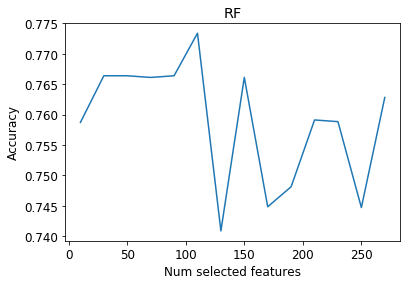

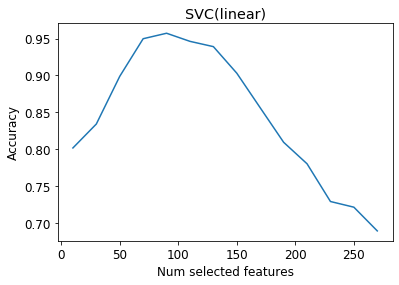

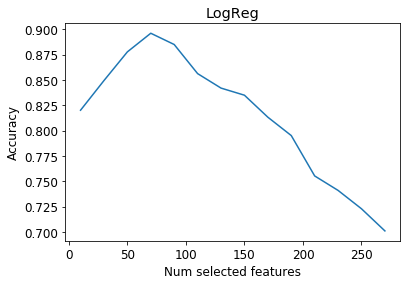

In [87]:
for model_name in model_names:        
    acc_vs_nfeats = np.asarray(acc_dict[model_name])
    print('{} - Acc: {:.2f} - Opt num feats: {} \n'.format(model_name, acc_vs_nfeats.max(), acc_vs_nfeats.argmax()*step+start))
for model_name in model_names:        
    plt.figure()
    plt.title(model_name)
    plt.xlabel('Num selected features')
    plt.ylabel("Accuracy")
    plt.plot(range(10, 276, step), acc_dict[model_name])
    plt.savefig('Features_selection_{}.png'.format(model_name),dpi = 400, bbox_inches='tight')
    plt.show()

The SVC(Linear) model with 90 selected features is the one that best predicts the labels. We will use it to explore the data and predict the labels of the test set

## Reduced data sets with selected features


In [71]:
X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

print('Train data shape: ' + str(X_train.shape))
print('Test data shape: ' + str(X_test.shape))

Train data shape: (276, 276)
Test data shape: (220, 276)


In [72]:
acc_vs_nfeats = np.asarray(acc_dict['SVC(linear)'])
n_feats = acc_vs_nfeats.argmax()*step+start

In [73]:
# selected features using SVC linear model   
rfe_SVC = RFE(SVC(kernel='linear', random_state=0), n_feats)
rfe_SVC = rfe_SVC.fit(X_train, y_train.values.ravel())

sel_feats = X_train.columns[rfe_SVC.support_]

In [74]:
# reduced training and test sets
X_train_red = X_train[sel_feats] 
X_test_red = X_test[sel_feats] 

In [75]:
print('Reduced train data shape: ' + str(X_train_red.shape))
print('Reduced test data shape: ' + str(X_test_red.shape))

Reduced train data shape: (276, 90)
Reduced test data shape: (220, 90)


In [76]:
# Save train and test sets with selected features
X_train_red.to_csv('train_set_reduced.csv', index = False)
X_test_red.to_csv('test_set_reduced.csv', index = False)

## Compare model performance with all the features vs selected features

In [77]:
SVC_clf = SVC(kernel='linear')
SVC_clf.fit(X_train_red, y_train)
SVC_clf_scores = cross_val_score(SVC_clf, X_train_red, y_train, cv=10, scoring='accuracy')

SVC_clf_all = SVC(kernel='linear')
SVC_clf_all.fit(X_train, y_train)
SVC_clf_scores_all = cross_val_score(SVC_clf_all, X_train, y_train, cv=10, scoring='accuracy')

print('Linear SVC accuracy all features: {:.2f}'.format(SVC_clf_scores_all.mean()))
print('Linear SVC accuracy with selected features: {:.2f}'.format(SVC_clf_scores.mean()))

Linear SVC accuracy all features: 0.69
Linear SVC accuracy with selected features: 0.96


## Selected features data exploration

Study correlation between selected features and target variable.

In [105]:
corr = X_train_red.corrwith(y_train)

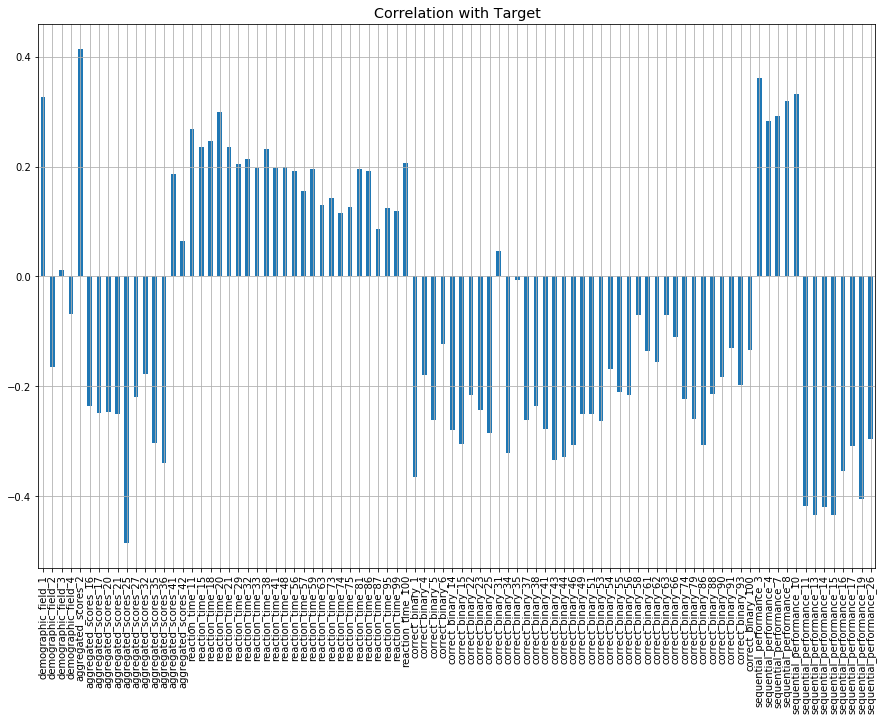

In [106]:
corr.plot.bar(figsize = (15, 10), title = "Correlation with Target", fontsize = 10,grid = True)
plt.savefig('feature_corr.png',dpi = 400, bbox_inches='tight')
plt.show()

## Get the 10 featueres with the largest correlation to the target variable.

In [111]:
corr_abs=abs(corr)
corr_abs.nlargest(10)

aggregated_scores_25         0.484589
sequential_performance_13    0.434606
sequential_performance_15    0.434459
sequential_performance_14    0.419069
sequential_performance_11    0.417614
aggregated_scores_2          0.414070
sequential_performance_19    0.404667
correct_binary_1             0.364190
sequential_performance_3     0.361284
sequential_performance_16    0.353589
dtype: float64

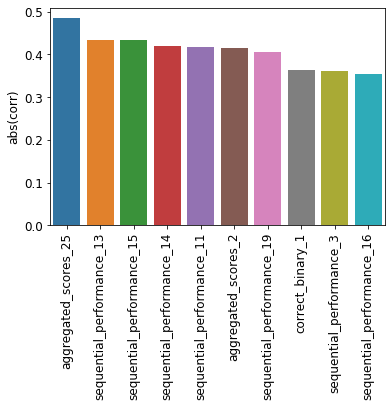

In [119]:
feats = sns.barplot(corr_abs.nlargest(10).index, corr_abs.nlargest(10).values)
for item in feats.get_xticklabels():
    item.set_rotation(90)
plt.ylabel('abs(corr)')
plt.savefig('10feats.png',dpi = 400, bbox_inches='tight')
plt.show()

'aggregated_scores' 25 and 2 and 'sequential_performance' 13, 15, 14, 15, 11 and 19 are the variables with the largest correlation to the target variable, this is, the ones that best predict the target variable. 

More insight could be given if we had more details about these variables.

# 4. Final model: SVC(Linear) with selected features
## Labels prediction with SVC model with selected features

In [83]:
SVC_clf = SVC(kernel='linear')
SVC_clf.fit(X_train_red, y_train)
y_pred = SVC_clf.predict(X_test_red)
SVC_clf_scores = cross_val_score(SVC_clf, X_train_red, y_train, cv=10, scoring='accuracy')

print('Linear SVC accuracy with selected features: {:.2f}'.format(SVC_clf_scores.mean()))

Linear SVC accuracy with selected features: 0.96


In [84]:
label_predictions = np.column_stack((patientId, y_pred))

In [85]:
label_predictions = pd.DataFrame(label_predictions, columns = ['id', 'prediction'])

In [86]:
label_predictions.to_csv('test_set_label_predictions.csv', index = False)

In [ ]:
# visualise predicted labels
sns.countplot(y_pred)
plt.title('Training labels')
plt.xlabel('Label value')
plt.ylabel('Count')
plt.savefig('Predicted labels.png',dpi = 400, bbox_inches='tight')
plt.show()